In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import os
import sys
import warnings
import tqdm
sys.path.append('..')

C:\Users\applepy\AppData\Roaming\Python\Python311\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
import xgboost as xgb
import yaml
import statsmodels.api as sm
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, recall_score, roc_auc_score, f1_score
from statsmodels.stats.outliers_influence import variance_inflation_factor 
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster import hierarchy
import optuna
from functools import partial
import scipy.spatial.distance as ssd
from sklearn.decomposition import PCA

In [3]:
import src.dax_utils as utils

In [4]:
pd.options.display.float_format = '{:.2f}'.format
plt.style.use('bmh')
warnings.filterwarnings("ignore")

In [5]:
import importlib
importlib.reload(utils)

<module 'src.dax_utils' from 'E:\\working\\pet-project\\investment-2024\\daxex\\_repo\\dax-24-strat\\proof_of_concept\\..\\src\\dax_utils.py'>

### Constants

In [6]:
FEATURE_SELECTION_AUC_DROP_THRESHOLD = .05

### Read in artifacts

In [7]:
X_train = pd.read_csv('dataset/X_train.csv', index_col=0, parse_dates=[0])
y_train = pd.read_csv('dataset/y_train.csv', index_col=0, parse_dates=[0])
X_test = pd.read_csv('dataset/X_test.csv', index_col=0, parse_dates=[0])
y_test = pd.read_csv('dataset/y_test.csv', index_col=0, parse_dates=[0])

In [8]:
X_train.shape

(3204, 2014)

In [9]:
y_train.value_counts(normalize=True)

target
0        0.58
1        0.42
Name: proportion, dtype: float64

### Baseline model

In [10]:
xgb_model = xgb.XGBClassifier(N_estimators=1200, random_state=42)
xgb_model.fit(X_train, y_train)

XGBClassifier(N_estimators=1200, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [11]:
y_prob = xgb_model.predict_proba(X_test)
optimal_threshold = utils.Tools.find_optimal_threshold((y_test == 1).astype(int), y_prob[:,1], roc_auc_score) # f1_score roc_auc_score

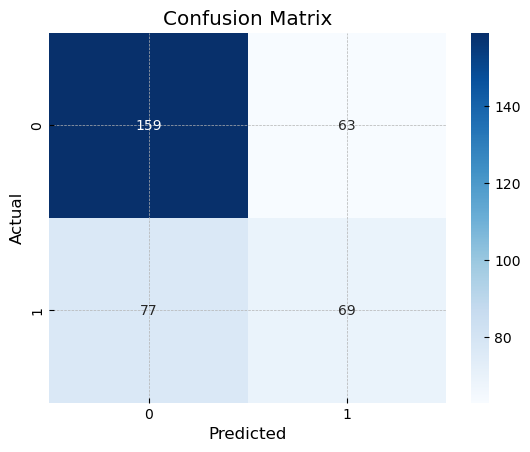

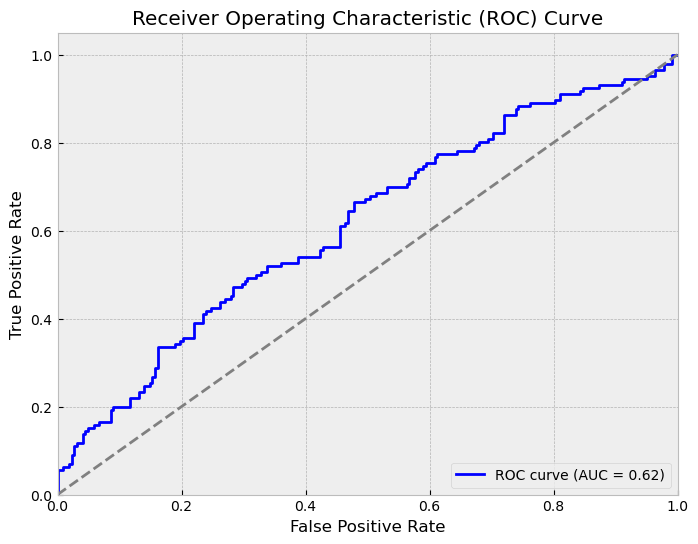

              precision    recall  f1-score   support

           0       0.67      0.72      0.69       222
           1       0.52      0.47      0.50       146

    accuracy                           0.62       368
   macro avg       0.60      0.59      0.60       368
weighted avg       0.61      0.62      0.62       368



In [12]:
utils.Tools.performance_report(y_test, y_prob, optimal_threshold)

### Feature Selection

Lasso selection

In [13]:
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel

In [14]:
sel_ = SelectFromModel(Lasso(alpha=0.001, random_state=0))

# train Lasso model and select features
sel_.fit(X_train, y_train)

SelectFromModel(estimator=Lasso(alpha=0.001, random_state=0))

In [15]:
X_train = X_train[X_train.columns[sel_.get_support()]]
X_test = X_test[X_test.columns[sel_.get_support()]]

In [16]:
X_train.shape

(3204, 929)

In [17]:
xgb_model = xgb.XGBClassifier(N_estimators=1200, random_state=42)
xgb_model.fit(X_train, y_train)

XGBClassifier(N_estimators=1200, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [18]:
y_prob = xgb_model.predict_proba(X_test)
optimal_threshold = utils.Tools.find_optimal_threshold((y_test == 1).astype(int), y_prob[:,1], roc_auc_score) # f1_score roc_auc_score

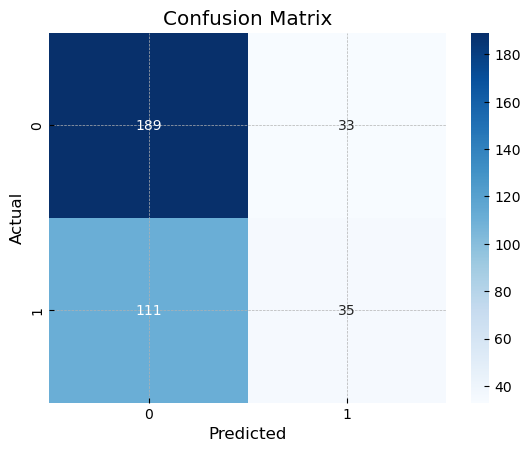

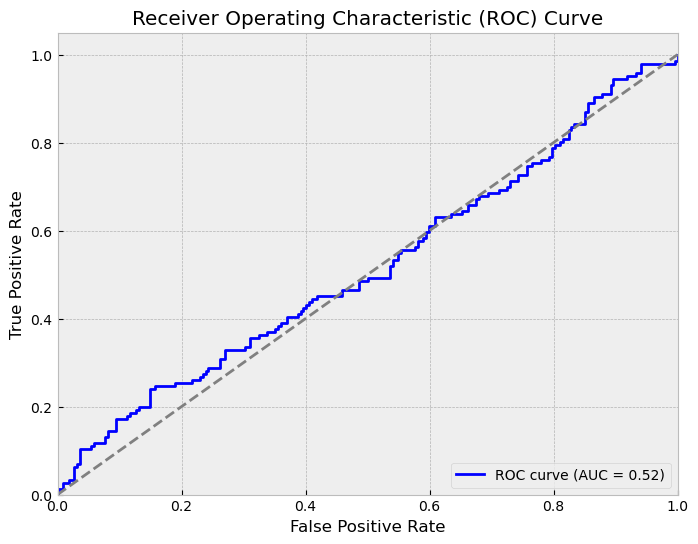

              precision    recall  f1-score   support

           0       0.63      0.85      0.72       222
           1       0.51      0.24      0.33       146

    accuracy                           0.61       368
   macro avg       0.57      0.55      0.53       368
weighted avg       0.58      0.61      0.57       368



In [19]:
utils.Tools.performance_report(y_test, y_prob, optimal_threshold)

Logreg

In [20]:
X_sm_train = sm.add_constant(X_train)
model = sm.Logit(y_train, X_sm_train)
results = model.fit()

Optimization terminated successfully.
         Current function value: 0.319580
         Iterations 15


In [21]:
number_of_significant_features = (results.pvalues < .05).sum() # 42

In [22]:
number_of_significant_features

265

In [23]:
results.pvalues[results.pvalues < .05].sort_values().head(15)

const                                           0.00
close_bnd_ief_corr10d high_spy_high_vol3d       0.00
close_ief_gld_corr30d year_days_passed          0.00
close_bnd_gld_corr30d close_bnd_spy_corr10d     0.00
close_spy_gld_corr10d close_gdaxi_spy_corr30d   0.00
sunrise_dusk close_bnd_gld_corr10d              0.00
close_ief_spy_corr30d close_bnd_spy_corr30d     0.00
close_spy_gld_corr10d close_ief_vol5d           0.00
sunrise_dusk close_gdaxi_gld_corr10d            0.00
high_gld_high_vol3d high_bnd_high_vol5d         0.00
close_bnd_gld_corr30d close_ief_gdaxi_corr10d   0.00
sunrise_dusk close_bnd_gld_corr30d              0.00
sunrise_dusk close_spy_vol3d                    0.00
close_gdaxi_spy_corr30d close_gdaxi_vol5d       0.00
close_spy_gld_corr30d close_ief_gld_corr10d     0.00
dtype: float64

In [24]:
X_train = X_train[[c for c in X_train.columns if c in results.pvalues[results.pvalues < .05]]]
X_test = X_test[[c for c in X_train.columns if c in results.pvalues[results.pvalues < .05]]]

In [25]:
X_train.shape

(3204, 264)

In [26]:
tree_based_feature_importances = utils.Tools.get_tree_model_feature_importances(xgb_model, X_train.columns)

In [27]:
tree_based_feature_importances.tail(15)

close_bnd_spy_corr10d high_bnd_high_vol5d         0.00
close_gdaxi_gld_corr10d close_gdaxi_gld_corr30d   0.00
volume_gld open_gld_day20                         0.00
close_ief_gld_corr30d low_gld_low_vol5d           0.00
high_spy_high_vol5d                               0.00
low_gld_low_vol5d low_gld_low_vol3d               0.00
close_bnd_gdaxi_corr30d close_bnd_vol5d           0.00
gld_rsi high_gld_day20                            0.00
close_gdaxi_spy_corr30d close_bnd_gld_corr30d     0.00
close_gdaxi_vol5d high_spy_day7                   0.00
spy_rsi low_ief_low_vol3d                         0.00
open_gdaxi_day1 volume_ief_day3                   0.00
close_spy_gld_corr30d year_days_passed            0.00
volume_gdaxi_day3 volume_bnd_day3                 0.00
close_bnd_gdaxi_corr30d close_gdaxi_gld_corr30d   0.00
dtype: float32

In [28]:
X_train = X_train[[c for c in X_train.columns if c not in tree_based_feature_importances[tree_based_feature_importances == 0].index]]
X_test = X_test[[c for c in X_train.columns if c not in tree_based_feature_importances[tree_based_feature_importances == 0].index]]

In [29]:
X_train.shape

(3204, 249)

Forward Selection

In [30]:
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import precision_score, f1_score, make_scorer

In [31]:
# from sklearn.metrics import precision_score, roc_auc_score

# def combined_score(y_true, y_pred, precision_weight=0.2):
#     """
#     Computes a combined score using precision and AUC scores.

#     Parameters:
#     - y_true: array-like of shape (n_samples,) - True binary labels.
#     - y_pred: array-like of shape (n_samples,) - Predicted binary labels.
#     - precision_weight: float, default=0.5 - Weight of the precision score in the combined score.

#     Returns:
#     - combined_score: float - The combined score.
#     """
#     precision = precision_score(y_true, y_pred)
#     f1 = f1_score(y_true, y_pred)
    
#     combined_score = precision_weight * precision + (1 - precision_weight) * f1
#     return combined_score

In [32]:
# # Build EXC classifier to use in feature selection
# # clf = ExtraTreesClassifier(n_estimators=60, n_jobs=-1, random_state=42)
# clf = xgb.XGBClassifier(random_state=42)
# timeseries_splitter = utils.ReasonableTimeSeriesSplit(n_splits=4)
# combined_scorer = make_scorer(combined_score, greater_is_better=True)

# # Build step forward feature selection
# sfs1 = sfs(clf, 
#            n_jobs=-1,
#            k_features=30,
#            forward=True,
#            floating=False,
#            verbose=2,
#            scoring=combined_score, # 'f1'
#            cv=timeseries_splitter) # 4

# # Perform SFFS
# sfs1 = sfs1.fit(X_train, y_train) 

In [33]:
import numpy as np
from sklearn.model_selection import BaseCrossValidator
from sklearn.metrics import precision_score, f1_score, make_scorer
from xgboost import XGBClassifier
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

In [34]:
def combined_score(y_true, y_pred, precision_weight=0.1):
    """
    Computes a combined score using precision and F1 scores.

    Parameters:
    - y_true: array-like of shape (n_samples,) - True binary labels.
    - y_pred: array-like of shape (n_samples,) - Predicted binary labels.
    - precision_weight: float, default=0.5 - Weight of the precision score in the combined score.

    Returns:
    - combined_score: float - The combined score.
    """
    precision = precision_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    
    combined_score = precision_weight * precision + (1 - precision_weight) * f1
    return combined_score

In [35]:
class ReasonableTimeSeriesSplit(BaseCrossValidator):
    def __init__(self, n_splits):
        self.n_splits = n_splits

    def split(self, X, y=None, groups=None):
        n_samples = len(X)
        split_size = n_samples // (self.n_splits + 1)
        indices = np.arange(n_samples)

        for i in range(self.n_splits):
            train_start = i * split_size
            train_end = (i + 1) * split_size
            test_start = train_end
            test_end = test_start + split_size
            
            if test_end > n_samples:
                test_end = n_samples

            train_indices = indices[train_start:train_end]
            test_indices = indices[test_start:test_end]

            yield train_indices, test_indices

    def get_n_splits(self, X=None, y=None, groups=None):
        return self.n_splits



# Create a scorer using make_scorer
combined_scorer = make_scorer(combined_score, greater_is_better=True)

clf = XGBClassifier(N_estimators=1200, random_state=42)
timeseries_splitter = ReasonableTimeSeriesSplit(n_splits=4)

# Build step forward feature selection
sfs1 = SFS(clf, 
           k_features=30,
           forward=True,
           floating=False,
           verbose=2,
           scoring=combined_scorer,  # Use the custom scorer
           cv=timeseries_splitter,
           n_jobs=-1)

# Example usage
# X, y should be your dataset


In [36]:
sfs1.fit(X_train, y_train)
feat_cols = list(sfs1.k_feature_idx_)
print(feat_cols)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 249 out of 249 | elapsed:    7.3s finished

[2024-07-21 20:26:47] Features: 1/30 -- score: 0.45877536407108205[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 248 out of 248 | elapsed:    5.8s finished

[2024-07-21 20:26:53] Features: 2/30 -- score: 0.4871080226573462[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 247 out of 247 | elapsed:    6.8s finished

[2024-07-21 20:27:00] Features: 3/30 -- score: 0.4

TypeError: 'NoneType' object is not iterable

In [ ]:
# feat_cols =  [27, 58, 61, 64, 74, 80, 82, 97, 121, 122, 139, 189, 198, 206, 209, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 242, 246, 286, 287, 328, 364, 376, 425, 441, 456, 459, 467, 495, 503, 510, 518, 562, 565, 604, 636, 645, 646]

In [ ]:
X_train.columns[feat_cols]

In [ ]:
X_train = X_train[X_train.columns[feat_cols]]
X_test = X_test[X_test.columns[feat_cols]]

In [ ]:
xgb_model = xgb.XGBClassifier(random_state=42)
xgb_model.fit(X_train, y_train)

In [ ]:
y_prob = xgb_model.predict_proba(X_test)
optimal_threshold = utils.Tools.find_optimal_threshold((y_test == 1).astype(int), y_prob[:,1], roc_auc_score) # f1_score roc_auc_score

In [ ]:
utils.Tools.performance_report(y_test, y_prob, optimal_threshold)

In [ ]:
import shap

In [ ]:
shap_values = shap.TreeExplainer(xgb_model).shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")

### Recurise Feature Elimination with Custom TimeSeriesSplit

In [ ]:
# baseline_score = roc_auc_score(y_test, y_prob[:,1])
# baseline_score

In [ ]:
scores = list()
timeseries_splitter = utils.ReasonableTimeSeriesSplit(n_splits=3)

for train_index, test_index in timeseries_splitter.split(X_train):
    # print("TRAIN:", len(train_index), "TEST:", len(test_index))
    xgb_model = xgb.XGBClassifier(random_state=42)
    xgb_model.fit(X_train.iloc[train_index,:], y_train.iloc[train_index])
    
    scores.append(
        roc_auc_score(y_train.iloc[test_index], xgb_model.predict_proba(X_train.iloc[test_index,:])[:,1])
    )

In [ ]:
baseline_score = np.array(scores).mean()
baseline_score

In [ ]:
import importlib
importlib.reload(utils)

In [ ]:
del RFE_FEATURES; del _RFE_FEATURES

In [ ]:
X_train.columns.shape[0]

In [ ]:
big_step, small_step = 3, 1
timeseries_splitter = utils.ReasonableTimeSeriesSplit(n_splits=6)
number_of_features = X_train.columns.shape[0] - big_step
step = big_step
current_score = baseline_score
all_scores = {}

progress_bar = tqdm.tqdm(total=number_of_features, desc="Processing")

n = 0
while current_score > (baseline_score - FEATURE_SELECTION_AUC_DROP_THRESHOLD) and number_of_features > 0:
    try:
        RFE_FEATURES = _RFE_FEATURES.copy()
    except NameError:
        RFE_FEATURES = X_train.columns
    
    rfe = RFE(estimator=xgb_model, n_features_to_select=number_of_features)
    rfe.fit(X_train[RFE_FEATURES], y_train)
    
    _RFE_FEATURES = X_train[RFE_FEATURES].columns[rfe.support_]
    
    scores = list()
    for train_index, test_index in timeseries_splitter.split(X_train):
        # print("TRAIN:", len(train_index), "TEST:", len(test_index))
        xgb_model = xgb.XGBClassifier(random_state=42)
        xgb_model.fit(X_train.iloc[train_index,:].loc[:,_RFE_FEATURES], y_train.iloc[train_index])

        scores.append(
            roc_auc_score(y_train.iloc[test_index], xgb_model.predict_proba(X_train.iloc[test_index,:].loc[:,_RFE_FEATURES])[:,1])
        )

    current_score = np.array(scores).mean()
    all_scores[number_of_features] = scores.copy()
    
    if n % 5 == 0:
        FEATURE_SELECTION_AUC_DROP_THRESHOLD = FEATURE_SELECTION_AUC_DROP_THRESHOLD - .01
        step = step - 1
        
    number_of_features = number_of_features - step
    progress_bar.set_description(f"Processing (AUC: {current_score:.4f})")
    progress_bar.update(step)
    n += 1

progress_bar.close()

In [ ]:
RFE_FEATURES

### Test Reduced Feature Set

In [ ]:
xgb_model = xgb.XGBClassifier(random_state=42)
xgb_model.fit(X_train[RFE_FEATURES], y_train)

In [ ]:
y_prob = xgb_model.predict_proba(X_test[RFE_FEATURES])
optimal_threshold = utils.Tools.find_optimal_threshold((y_test == 1).astype(int), y_prob[:,1], roc_auc_score) # f1_score roc_auc_score

In [ ]:
utils.Tools.performance_report(y_test, y_prob, optimal_threshold)

In [ ]:
# shap_values = shap.TreeExplainer(xgb_model).shap_values(X_train)
# shap.summary_plot(shap_values, X_train, plot_type="bar")

### Hyperparam optimization

In [ ]:
def objective_xgboost_classification(X_train, y_train, trial):

    # _X_train, X_valid = X_train[:int(X_train.shape[0] * .7)], X_train[int(X_train.shape[0] * .7):]
    # _y_train, y_valid = y_train[:int(X_train.shape[0] * .7)], y_train[int(X_train.shape[0] * .7):]

    params = {
        'n_estimators': trial.suggest_int('n_estimators', 900, 2000),
        'max_depth': trial.suggest_int('max_depth', 8, 18),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1e-1),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.8, 1.0),
        'gamma': trial.suggest_float('gamma', 1e-4, 1e-1),
        'min_child_weight': trial.suggest_int('min_child_weight', 6, 9),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-3, 1e-1),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-2, 1e-1),
        'use_label_encoder': False,
        'eval_metric': 'auc',
        'verbose' : -1
    }
    
    steps = 5
    timeseries_splitter = ReasonableTimeSeriesSplit(n_splits=steps)
    scores = np.empty(steps)
    
    for idx, (train_index, test_index) in enumerate(timeseries_splitter.split(X_train)):
        xgb_model = xgb.XGBClassifier(**params, random_state=42)
        xgb_model.fit(X_train.iloc[train_index,:], y_train.iloc[train_index])
        scores[idx] = roc_auc_score(y_train.iloc[test_index], 
                                    xgb_model.predict_proba(X_train.iloc[test_index,:])[:,1])

    
    # Initialize the XGBoost classifier model with hyperparameters
    # model = xgb.XGBClassifier(**params, random_state=42)
    
    # Train the model
    # model.fit(_X_train, _y_train)
    
    # Evaluate the model on the validation set using AUC
    # y_pred_proba = model.predict_proba(X_valid)[:, 1]
    # score = roc_auc_score(y_valid, y_pred_proba)
    # score = recall_score(y_valid, y_pred_proba)
    
    return scores.mean()

In [ ]:
# Define the study and optimize hyperparameters
study_xgboost_classification = optuna.create_study(direction='maximize')
objective = partial(objective_xgboost_classification, X_train.loc[:,RFE_FEATURES], y_train)
study_xgboost_classification.optimize(objective, n_trials=400)

In [ ]:
best_params = study_xgboost_classification.best_params
best_auc = study_xgboost_classification.best_value

print("Best AUC:", best_auc)
print("Best Hyperparameters:", best_params)

Best parameters

In [ ]:
RFE_FEATURES

In [ ]:
xgb_model = xgb.XGBClassifier(**best_params, random_state=42)
xgb_model.fit(X_train[RFE_FEATURES], y_train)

In [ ]:
y_prob = xgb_model.predict_proba(X_test[RFE_FEATURES])
optimal_threshold = utils.Tools.find_optimal_threshold((y_test == 1).astype(int), y_prob[:,1], roc_auc_score) # f1_score roc_auc_score

In [ ]:
os.makedirs('../config', exist_ok=True)
    
config = {
    'selected_features' : list(RFE_FEATURES),
    'threshold' : float(optimal_threshold[0]),
    'xgb_classifier_params' : best_params
}

with open('../config/config.yaml', 'w') as file:
    yaml.dump(config, file, default_flow_style=False)

In [ ]:
utils.Tools.performance_report(y_test, y_prob, optimal_threshold)

In [ ]:
# shap_values = shap.TreeExplainer(xgb_model).shap_values(X_train)
# shap.summary_plot(shap_values, X_train, plot_type="bar")